# Weighted Finite State Machines using OpenFST

- Evgeny A. Stepanov
- stepanov.evgeny.a@gmail.com

Dan Jurafsky and James H. Martin's __Speech and Language Processing__ ([3rd ed. draft](https://web.stanford.edu/~jurafsky/slp3/)) is advised for reading. 

This notebook covers Lecture on __Weighted Finite State Transducers__ using OpenFST Tools. 
Content-wise, it partially copies [OpenFST Quick Tour](http://www.openfst.org/twiki/bin/view/FST/FstQuickTour).
The level of presentation is kept intermediate and not all tools and operations are covered.

*Chapter 2: "Regular Expressions, Text Normalization, Edit Distance"* is useful for background.

__Requirements__

- [OpenFST](http://www.openfst.org/twiki/bin/view/FST/WebHome)
- [Graphviz](https://graphviz.gitlab.io/) for visualization __[OPTIONAL]__
- Mohri et al. (1996) [FSM Toolkit Exercises](https://github.com/esrel/LUS/blob/master/extras/Mohri_FST_ex.pdf)
    - copied into notebook for convenience

__Abbreviations__


|__ABBR__ | __Meaning__
|:--------|:----------------------
| __FSA__ | Finite State Acceptor
| __FST__ | Finite State Transducer
| __FSM__ | Finite State Machine (FSA + FST)


## 1. OpenFST Tools

### 1.1. File Formats

#### 1.1.1. Acceptor (FSA) & Transducer (FST) File

OpenFST specifies FSA/FSTs using a text file in the AT&T FSM format, like below.
(Read comments `#` for interpretation.)

In [1]:
%%bash
# arc format: src dest ilabel olabel [weight]
# final state format: state [weight]
# lines may occur in any order except initial state must be first line
# unspecified weights default to 0.0 (for the library-default Weight type) 
cat > fst.txt <<EOF
0 1 a x 0.5
0 1 b y 1.5
1 2 c z 2.5
2 3.5
EOF

The supported specifications are:
- acceptor (no output column, 4th)
- transducer

__Acceptor__ is an FSM with 1 tape (input), that *accepts/recognizes* input strings

__Transducer__ is an FSM with 2 tapes (input & output), that translates input to output string

__Weights__ are optional for both (default to 0)

#### 1.1.2. Symbol Table (Lexicon)

> The internal representation of an arc label is an integer. We must provide the mapping from symbols to integers explicitly with a symbol table file.

In case symbols of your FSM are integers as well (what are the odds?), the symbol table can be omitted.

Since in *transducer* there are two tapes (input and output), the mappings are provided for both via `--isymbols` and `--osymbols` command-line arguments, respectively.  

> You may use any string for a label; you may use any non-negative integer for a label ID. The zero label ID is reserved for the epsilon label, which is the empty string. We have included 0 in our table, even though it is not used in our example. Since subsequent FST operations might add epsilons, it is good practice to include a symbol for it.

Input and output symbol tables may differ. 
It's easier to avoid *human error*, using a unified symbol table for both input and output.

In [2]:
%%bash
# input symbols
cat > isyms.txt <<EOF
<eps> 0
a 1
b 2
c 3
EOF

In [3]:
%%bash
# output symbols
cat > osyms.txt <<EOF
<eps> 0
x 1
y 2
z 3
EOF

### 1.2. Using FST Tools

Please consult [OpenFST Quick Tour](http://www.openfst.org/twiki/bin/view/FST/FstQuickTour) for *Available FST Operations* List. Here we are going to list only some.

> The shell-level FST operations typically read one or more input binary FST files, call internally the corresponding C++ operation and then write an output binary FST file. If the output file is omitted, standard output is used. If the input file is also omitted (unary case) or is "-", then standard input is used. Specifically, they have the form:

- Unary Operations:

```bash
fstunaryop in.fst out.fst
fstunaryop < in.fst > out.fst
```

- Binary Operations:

```bash
fstbinaryop in1.fst in2.fst out.fst
fstbinaryop - in2.fst < in1.fst > out.fst
```

#### 1.2.1. Basic Commands

##### Compiling
The text FSM must be converted into a binary FSM file before it can be used by the OpenFst library. 

It is possible to store symbol input and/or output tables together with the compiled FSM providing `--keep_isymbols` and `--keep_osymbols` flags, respectively.

In [4]:
%%bash
# to compile a binary fst from text
fstcompile --isymbols=isyms.txt --osymbols=osyms.txt fst.txt fst.bin

In [5]:
%%bash
# to store symbol tables with the created fst (advised!)
fstcompile --isymbols=isyms.txt --osymbols=osyms.txt --keep_isymbols --keep_osymbols fst.txt fst_sym.bin

##### Printing
If `--keep_isymbols` and `--keep_osymbols` flags were provided during compilation, `--isymbols` and `--osymbols` arguments can be omitted.

In [6]:
%%bash
# to print binary fst as text
fstprint --isymbols=isyms.txt --osymbols=osyms.txt fst.bin fst_out.txt

##### Drawing
Similar to `fstprint`, if `--keep_isymbols` and `--keep_osymbols` flags were provided during compilation, `--isymbols` and `--osymbols` arguments can be omitted.

In [7]:
%%bash
# to produce dot file for visualization with Graphviz
fstdraw --isymbols=isyms.txt --osymbols=osyms.txt fst.bin fst.dot

# the dot file can be converted to ps (or other format) as
# dot -Tps fst.dot > fst.ps

##### Printing Summary Information

Besides useful information on FSM structure, `farinfo` summary includes information regarding whether input and output symbols are stored: on `input symbol table` and `output symbol table` lines.

In [8]:
%%bash
# to print-out fst summary information (remove 'head -n 8' to see full summary)
fstinfo fst.bin | head -n 8

fst type                                          vector
arc type                                          standard
input symbol table                                none
output symbol table                               none
# of states                                       3
# of arcs                                         3
initial state                                     0
# of final states                                 1


In [9]:
%%bash
# to print-out fst summary information (remove 'head -n 8' to see full summary)
fstinfo fst_sym.bin | head -n 8

fst type                                          vector
arc type                                          standard
input symbol table                                isyms.txt
output symbol table                               osyms.txt
# of states                                       3
# of arcs                                         3
initial state                                     0
# of final states                                 1


##### Compiling & Printing an Acceptor

Even though the library supports both acceptors and transducers, the default internal format is that of a transducer. Consequently, working with acceptors, some commands (e.g. `fstcompile`) require providing special `--acceptor` flag to signal that the input is in acceptor format.

Use `--help` flag of the commands to check the required input.

In [10]:
%%bash
cat > fsa.txt <<EOF
0 1 a
0 1 b
1 2 c
2
EOF

In [11]:
%%bash
fstcompile --acceptor --isymbols=isyms.txt --keep_isymbols fsa.txt fsa.bin

In [12]:
%%bash
fstprint fsa.bin

0	1	a	1
0	1	b	2
1	2	c	3
2


From the output of the command above we can observe that:
- acceptor is internally represented as transducer (there are 4 columns)
- keeping symbols allows printing symbols in textual specification without providing symbol tables (3rd column)
- symbol tables are managed separately (4th column is integers, since we didn't provide `--osymbols` and `--keep_osymbols`)

In [13]:
%%bash
fstinfo fsa.bin | head -n 8

fst type                                          vector
arc type                                          standard
input symbol table                                isyms.txt
output symbol table                               none
# of states                                       3
# of arcs                                         3
initial state                                     0
# of final states                                 1


#### 1.2.2. Managing Symbol Tables [Optional: Advanced]

Symbol tables stored with the compiled FSM, besides providing convenience for printing and drawing using `fstprint` and `fstdraw`, are also compared during *some* operations for compatibility (in case both binary FSMs store them). The feature is enabled by default.

```bash
Flags from: symbol-table.cc
  --fst_compat_symbols: type = bool, default = true
  Require symbol tables to match when appropriate
```

OpenFST Library provides `fstsymbols` tool that performs operations (export, set, clear, relabel) on the symbol tables attached to a __binary__ FSM. 

For demonstration, let's 
- clear symbol table of the acceptor above compiled with `--keep_isymbols`
- export symbol table as `fsa.sym` 
- print FSM summary before and after using `fstinfo`

In [14]:
%%bash
fstinfo fsa.bin | head -n 4

fst type                                          vector
arc type                                          standard
input symbol table                                isyms.txt
output symbol table                               none


In [15]:
%%bash
fstsymbols --save_isymbols=fsa.sym --clear_isymbols fsa.bin fsa_nosym.bin
fstinfo fsa_nosym.bin | head -n 4

fst type                                          vector
arc type                                          standard
input symbol table                                none
output symbol table                               none


In [16]:
%%bash
cat fsa.sym 

<eps>	0
a	1
b	2
c	3


#### 1.2.3. Symbol Table Compatibility Check [Optional: Advanced]
As we have mentioned, symbol tables stored with the compiled FSMs are compared during *some* operations for compatibility (in case both binary FSMs store them). What this means in practice is that if two symbol tables map the same symbol to different IDs, they are considered different.

This can be demonstrated compiling the same FSA with different symbol tables, and using it in an operation with an FST that has symbol table fully compatible only with one of the symbol tables of an FSA. (Ignore the operation for now.)

```bash
cat > fsa.txt <<EOF
0 1 a
0 1 b
1 2 c
2
EOF

cat > fst.txt <<EOF
0 1 a x 0.5
0 1 b y 1.5
1 2 c z 2.5
2 3.5
EOF
```

In [17]:
%%bash
cat > isyms_a.txt <<EOF
<eps> 0
a 1
b 2
c 3
EOF

cat > isyms_b.txt <<EOF
<eps> 0
a 4
b 2
c 3
EOF

cat > isyms_c.txt <<EOF
<eps> 0
a 2
b 3
c 1
EOF

cat > osyms.txt <<EOF
<eps> 0
x 1
y 2
z 3
EOF

In [18]:
%%bash
fstcompile --isymbols=isyms_a.txt --osymbols=osyms.txt --keep_isymbols --keep_osymbols fst.txt fst.bin
fstcompile --acceptor --isymbols=isyms_a.txt --keep_isymbols fsa.txt fsa_a.bin
fstcompile --acceptor --isymbols=isyms_b.txt --keep_isymbols fsa.txt fsa_b.bin
fstcompile --acceptor --isymbols=isyms_c.txt --keep_isymbols fsa.txt fsa_c.bin

In the output below observe that the output of the operation with:
- `fsa_a.bin` yields FST identical to the original
- `fsa_b.bin` doesn't have $a \rightarrow x$ transition, since `a` is mapped to `1` in symbol table (a) and to `4` in (b)
- `fsa_c.bin` doesn't yield any output, since none of the symbol-ID pairs in symbol tables (a) & (c) match.

In [19]:
%%bash 
fstcompose fsa_a.bin fst.bin | fstprint

0	1	a	x	0.5
0	1	b	y	1.5
1	2	c	z	2.5
2	3.5


In [20]:
%%bash 
fstcompose fsa_b.bin fst.bin | fstprint

0	1	b	y	1.5
1	2	c	z	2.5
2	3.5


In [21]:
%%bash 
fstcompose fsa_c.bin fst.bin | fstprint

### 1.3. Regular Expressions & Closure Properties & OpenFST Commands

#### 1.3.1. Regular Expressions
- $\emptyset$ is a Regular Expression
- Each symbol from $\Sigma$ is a Regular Expression
- If $\alpha$ and $\beta$ are Regular Expressions, then so is $(\alpha \circ \beta)$
- If $\alpha$ and $\beta$ are Regular Expressions, then so is $(\alpha \cup \beta)$
- If $\alpha$ is a Regular Expression, then so is $(\alpha^*)$

Languages expressed using Regular Expressions are called {\color{red} Regular Languages}

#### 1.3.2. Closure Properties of Regular Languages
Regular Languages are closed under following operations:

- __Intersection__: if $L_1$ and $L_2$ are RL, then so is $L_1 \cap L_2$, the language consisting of the set of strings in both $L_1$ and $L_2$
- __Difference__: if $L_1$ and $L_2$ are RL, then so is $L_1 - L_2$, the language consisting of the set of strings in both $L_1$ and not in $L_2$
- __Complementation__: if $L_1$ is a RL, then so is its complement $\bar{L_1}$
- __Reversal:__ if $L_1$ is a RL, then so is $L^R_1$,  the set of reversals of all strings in $L_1$

### 1.4. Acceptor Operations

| Operation              | Equation                 | Command 
|:-----------------------|--------------------------|:--------
| Concatenation (Product)| $$C=AB$$                 | `fstconcat A.fsa B.fsa > C.fsa`
| Union (Sum)            | $$C=A\cup B = A+B$$      | `fstunion A.fsa B.fsa > C.fsa`
| Kleene*                | $$C=B^*=B^0+B^1+... $$   | `fstclosure B.fsa > C.fsa`
| Intersection           | $$C=A\cap B = A\&B$$     | `fstintersect A.fsa B.fsa > C.fsa`
| Difference             | $$C=A-B$$                | `fstdifference A.fsa B.fsa > C.fsa`
| Reversal               | $$C=A^R$$                | `fstreverse A.fsa > C.fsa`
| Complement             | $$C=A^{-1}$$             | N/A

- __Difference__ requires its 2nd argument ($B$) to be unweighted & deterministic acceptor
- __Complement__ is not implemented due to:
    - Alphabet issue 
    - Non-determinism issue

#### Exercises

Given two acceptors, $A$ and $B$ (+ symbol table):
- compile them
- apply acceptor operations listed above (applicable ones)
- print (or draw, if graphviz is available) the resulting automaton ($C$)
    - you can also visualize the output of `fstdraw` [online](http://www.webgraphviz.com/)

In [22]:
%%bash

cat > A.txt <<EOF
0 0 a 0.5
0 1 b 0.3
1 2 c 0.0
1 2 d 0.6
2 0.8
EOF

cat > B.txt <<EOF
0 1 b 0.4
0 2 c 1.2
1
2 0.2
EOF

cat > lex.sym <<EOF
<eps> 0
a 1
b 2
c 3
d 4
<unk> 5
EOF

### 1.5. Useful OpenFST Library Operations and Utilities

#### 1.5.1. Frequently Used Operations

| Operation              | Command                        | Description 
|:-----------------------|:-------------------------------|:---------------------------
| Epsilon Removal        | `fstrmepsilon A.fsa > C.fsa`   | remove `<eps>` from fsm
| Trimming               | `fstconnect A.fsa > C.fsa`     | remove unreachable states from fsm
| Determinization        | `fstdeterminize A.fsa > C.fsa` | creates equiv. *deterministic* fsm 
| Minimization           | `fstminimize A.fsa > C.fsa`    | creates equiv. minimal deterministic fsm


#### 1.5.2. Sorting Utilities

| Operation   | Command      | Description 
|:------------|:-------------|:---------------------------
| Arc Sorting | `fstarcsort` | sorts the arcs in an fst per state
| FST Sorting | `fsttopsort` | sorts an fst so that all transitions are from lower to higher state IDs


### 1.6. Transducer Operations

As expected, transducer-specific operations are related to the existence of the second tape.

| Operation              | Equation                 | Command 
|:-----------------------|--------------------------|:--------
| Projection             | $$A=\pi_1(T)$$           | `fstproject A.fst > A.fsa`
| Inverse                |                          | `fstinvert A.fst > C.fst`
| Composition            |                          | `fstcompose A.fst B.fst > C.fst`

- __Projection__ converts a *transducer* into an *acceptor* by retaining only the input or the output tape
- __Inverse__ inverts a *transducer*, transposing the input and output symbols on each transition
- __Composition__ composes fsts:

    - given 2 fsts: $fst_1$ that transduces from $s_1$ to $s_2$ and $fst_2$ that transduces from $s_2$ to $s_3$, returns $fst_3$ that transduces from $s_1$ to $s_3$ with the $2$ costs combined
    - *acceptor* is treated as a *transducer* to itself

## 2. Working with Text

The primary use of FST Tools is text processing. Similar to NGram Library, where we were scoring sentences in a corpus by intersecting them with the ngram model, FSMs are applied (intersected, composed, etc.) to sentences represented as FSAs. Consequently, one of the most frequent operations is conversion of text to FSA. 

__Example__: *Lorem ipsum dolor sit amet*

<div>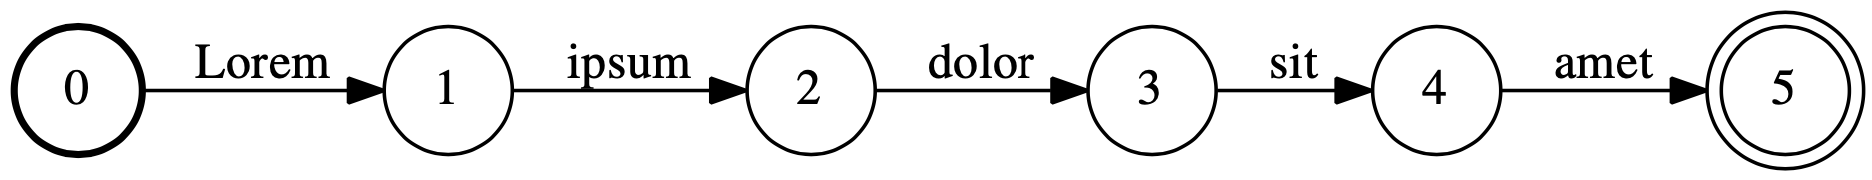</div>

### 2.1. String to FSA

While working with a *single* FSA, it is more convenient to generate it "manually".
- generate FSA specification from the input string as exemplified by function `txt2fsa`
- compile it into binary format
- apply necessary operations

In [23]:
def txt2fsa(txt):
    """
    generate an fsa of the input text (whitespace tokenization)
    :param txt: input string to generate automata for
    :return: fsa specification as string
    """
    sent = txt.strip().split()
    fsa = ''
    for i, word in enumerate(sent):
        # add [src state, dest state, arc label]
        fsa += " ".join([str(i), str(i + 1), word]) + "\n"
    
    # add final state
    fsa += str(i + 1)
    return fsa

In [24]:
fsa = txt2fsa("a b c")

print(fsa)

with open('tmp.txt', 'w') as f:
    f.write(fsa)

0 1 a
1 2 b
2 3 c
3


In [25]:
%%bash
fstcompile --acceptor --isymbols=lex.sym --keep_isymbols  tmp.txt tmp.fsa
fstprint --acceptor tmp.fsa


0	1	a
1	2	b
2	3	c
3


### 2.2. Corpus to FAR

As we have already seen, [FST Archives (FARs)](http://www.openfst.org/twiki/bin/view/FST/FstExtensions) is an extension that provides a set of tools to work with corpora. Specifically, conversion of a corpus to/from FAR, where each sentence of a corpus is represented as a finite-state automaton. 

#### 2.2.1. FAR Tools

__FARs__ -- *weighted  finite-state  machines  archives* -- a concatenation of the file representation of one or more finite-state machines.  

Commands:

| Command             | Description         |
|:--------------------|:--------------------|
| `farinfo`           | prints some basic information about the FSMs in an a finite-state archive
| `farcreate`         | creates a finite-state archive from input FSMs
| `farextract`        | extracts FSMs from a finite-state archive
| `farcompilestrings` | compiles a set of strings as FSMs and stores them in a finite-state archive
| `farprintstrings`   | prints as string FSMs in a finite-state archive
| `farequal`          | compares the FSMs in two finite-state archives for equality
| `farisomorphic`     | compares the FSMs in two finite-state archives for [isomorphism](https://en.wikipedia.org/wiki/Isomorphism)


Refer to [manual](http://www.openfst.org/twiki/bin/view/FST/FstExtensions\#FstArchives) for options.

##### Working with Symbol Tables
Since FAR Tools `farcompilestrings` and `farprintstrings` convert text into FSM and back, similar to `fstcompile` and `fstprint` tools, they take symbol table as an argument via `--symbols`. Unlike these tools, `farcompilestrings` is designed to create acceptors, thus there is only one symbol table (hence only `--symbols`).

In order to include symbol tables into compiled acceptors we provide `--keep_symbols` flag.

Since FAR contains a number of FSMs that share the symbol table, the tools additionally provide `--initial_symbols` flag to store/use symbol table of the first FSM in the archive only.

### 2.3. Testing FSMs with FAR
The common test for an FSM is whether it accepts input or not. This is achieved by intersecting the input sentence as FSA with the tested automaton. Often it is the case that we want to test several input strings at once. FARs seem to be the choice. Unfortunately, there is no direct way to "apply" an operation (or FSM) to a FAR archive (except `ngramapply` that intersects Language Model automaton with all sentences in FAR).

Iterative application of an operation (or several by piping) to all sentences in the FAR archive, that was compiled using `farcompilestring`, can be achieved using `farexract` and `farcreate`. 

`farextract` allows:
- to extract FSMs into a directory provided by `--filename_prefix`
- to control filename extension using `--filename_suffix`

`farcreate` takes a number of FSMs for far creation `farcreate [in1.fst [[in2.fst ...] out.far]]`; as well as a file that provides a list of files to include in FAR via `--file_list_input`.

It is possible to control the file naming using various flags.

### 2.4. Cleaning the Output
FSM operations often re-order/re-name/etc. the states and add `<epsilon>` transitions. Consequently, the output of `fstprint` is difficult to read. To achieve readability we can apply FSM operations on the output FSM to clean it.

1. get the best hypothesis with `fstshortestpath`
2. remove `<epsilon>` transitions with `fstrmepsilon`
3. sort states with `fsttopsort`

For instance:
```bash
fstintersect string.fsa test.fsa |\ 
    fstshortestpath |\
    fstrmepsilon |\
    fsttopsort |\
    fstprint
```

The "cleaned" FSM is sometimes required as an input for the subsequent operation. 
For such cases please consult the tool documentation.

### Exercises
Mohri et al. (1996) [FSM Toolkit Exercises](https://github.com/esrel/LUS/blob/master/extras/Mohri_FST_ex.pdf):

- on acceptors: 1, 2, 3
- on transducers: 5, 9

For each exercise:
- write test cases to apply fst to
- compile those into FAR using `farcompilestrings`
- use `farextract` and `farcompile` tools
- print accepted strings using `farprintstrings`

#### E1. 

Given the alphabet $L = \{a...z, A...Z\}$ + `<space>`, create an automaton that:

- accepts a letter in $L$ (including space).
- accepts a single space.
- accepts a capitalized word (where a word is a string of letters in $L$ excluding space and a capitalized word has its initial letter uppercase and remaining letters lowercase).
- accepts a word containing the letter $a$


#### E2.

Using the automata in E1 as the building blocks, use appropriate FSM operations on them to create an automaton that:

- accepts zero or more capitalized words followed by spaces.
- accepts a word beginning or ending in a capitalized letter (optional).
- accepts a word that is capitalized and contains the letter $a$.
- accepts a word that is capitalized or does not contain an $a$.
- accepts a word that is capitalized or does not contain an $a$ without using `fstunion` (optional). 

#### E3. 
- epsilon-remove, determinize, and minimize each of the automata in E2. 
- give the number of states and arcs before and after these operations.

#### E5.
Given the alphabet $\{a,b,...,z\}$ + `<space>`

- create a transducer that implements *rot13* cipher: 
    - $a \rightarrow n$
    - $b \rightarrow o$
    - ...
    - $m \rightarrow z$
    - $n \rightarrow a$
    - $o \rightarrow b$
    - ...
    - $z \rightarrow m$
- encode and decode the message "my secret message"
    - assume `<space>` $\rightarrow$ `<space>`

#### E9.
Given the alphabet $L = \{A, G, T, C\}$

- create transducer $T$ that implements [edit distance](https://en.wikipedia.org/wiki/Edit_distance)

    - $$d(x,x) = 0, x \in L$$
    - $$d(x,y) = d(x,\epsilon) = d(\epsilon,y) = 1, x \neq y \in L$$

- using $T$ find the best alignment between the strings "AGTCC" and "GGTACC"
- find the second best alignment